# Responsible Data Science Lab 9: LIME

In this lab, we will be using LIME, a package that provides "Locally Interpetable Model-agnostic Explanations" of machine learning models.

- Locally interpretable: for each specific prediction, we can provide a relevant explanation.
- Model-agnostic: we can provide the same sort of explanation for models of different classes.

For more documentation of the LIME package, see [here](https://github.com/marcotcr/lime) and [here](https://lime-ml.readthedocs.io/en/latest/index.html). The original paper describing the method is [here](https://arxiv.org/pdf/1602.04938.pdf).

In [1]:
!pip install lime

Defaulting to user installation because normal site-packages is not writeable


In [2]:
%matplotlib inline

import sklearn.model_selection
import sklearn.metrics
import sklearn.datasets
import sklearn.ensemble
import sklearn.preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import numpy as np
from IPython.display import Markdown, display
import matplotlib.pyplot as plt
import warnings
import lime
import lime.lime_tabular
from lime import submodular_pick
import xgboost
from xgboost import plot_importance
import json
from collections import OrderedDict

import pandas as pd

np.random.seed(1)

## Part 1: Prepare the data

We will be using the Adult dataset, which you are all familiar with by this point. Recall that the task is to predict whether a person makes over 50K dollars per year based on census information.

### Read in the data

In [3]:
# Read in the data
colnames = ["Age", "Workclass", "fnlwgt", "Education", "Education-Num", "Marital-Status","Occupation", "Relationship", "Race", "Sex", "Capital-Gain", "Capital-Loss","Hours-per-week", "Country", "income"]
data_df = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data',
                      names=colnames)
print("Shape: ", data_df.shape)
data_df.head()

Shape:  (32561, 15)


Age          Workclass  fnlwgt   Education  Education-Num  \
0   39          State-gov   77516   Bachelors             13   
1   50   Self-emp-not-inc   83311   Bachelors             13   
2   38            Private  215646     HS-grad              9   
3   53            Private  234721        11th              7   
4   28            Private  338409   Bachelors             13   

        Marital-Status          Occupation    Relationship    Race      Sex  \
0        Never-married        Adm-clerical   Not-in-family   White     Male   
1   Married-civ-spouse     Exec-managerial         Husband   White     Male   
2             Divorced   Handlers-cleaners   Not-in-family   White     Male   
3   Married-civ-spouse   Handlers-cleaners         Husband   Black     Male   
4   Married-civ-spouse      Prof-specialty            Wife   Black   Female   

   Capital-Gain  Capital-Loss  Hours-per-week         Country  income  
0          2174             0              40   United-States   <=50K  
1             0             0              13   United-States   <=50K  
2             0             0              40   United-States   <=50K  
3             0             0              40   United-States   <=50K  
4             0             0              40            Cuba   <=50K

### Clean the data

In [4]:
# Drop Education-Num, which has a functional dependancy with Education
print("Show functional dependency")
print(data_df.groupby(['Education','Education-Num']).size())
data_df.drop(['Education-Num'], axis=1, inplace=True)

Show functional dependency
Education     Education-Num
10th          6                  933
11th          7                 1175
12th          8                  433
1st-4th       2                  168
5th-6th       3                  333
7th-8th       4                  646
9th           5                  514
Assoc-acdm    12                1067
Assoc-voc     11                1382
Bachelors     13                5355
Doctorate     16                 413
HS-grad       9                10501
Masters       14                1723
Preschool     1                   51
Prof-school   15                 576
Some-college  10                7291
dtype: int64


In [5]:
# Get a list of feature names (excluding the outcome variable)
feature_names = data_df.columns[:-1]

In [6]:
# Mark labels and encode them using sklearn
labels = data_df.iloc[:,-1]
le= sklearn.preprocessing.LabelEncoder()
le.fit(labels)
labels = le.transform(labels)
class_names = le.classes_
data = data_df.iloc[:,:-1]
le_label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Class names: ", class_names)
print("Label mapping: ", le_label_mapping)

Class names:  [' <=50K' ' >50K']
Label mapping:  {' <=50K': 0, ' >50K': 1}


In [7]:
# Check if there are categorical varibles that we need to make dummies for
print(data.dtypes)
# Get a list of which variables are categorical
# we record the index of these columns since it is a required input format later in LIME
categorical_features  = [i for i in range(len(data.dtypes)) if data.dtypes[i]=='object']
print("Indices of categorical features: ", categorical_features)

Age                int64
Workclass         object
fnlwgt             int64
Education         object
Marital-Status    object
Occupation        object
Relationship      object
Race              object
Sex               object
Capital-Gain       int64
Capital-Loss       int64
Hours-per-week     int64
Country           object
dtype: object
Indices of categorical features:  [1, 3, 4, 5, 6, 7, 8, 12]


/var/folders/8p/pfvm32bd07q6ccc1n2qmv92w0000gn/T/ipykernel_43143/2960136732.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  categorical_features  = [i for i in range(len(data.dtypes)) if data.dtypes[i]=='object']
/var/folders/8p/pfvm32bd07q6ccc1n2qmv92w0000gn/T/ipykernel_43143/2960136732.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  categorical_features  = [i for i in range(len(data.dtypes)) if data.dtypes[i]=='object']
/var/folders/8p/pfvm32bd07q6ccc1n2qmv92w0000gn/T/ipykernel_43143/2960136732.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer key

LIME will require us to provde categorical variables as a single column, not as dummies, so we can't just explode these columns the way we normally would during pre-processing.

Instead, we'll use some sklearn tools to take the following steps:
1. Encode the existing categories with a number corresponding to each category
2. Make a dictionary storing the relationship between the original stirng category and the number we've replaced it with (categorical_names)
3. Make a function that we can use down the line to transform categorical variables into dummies

In [8]:
categorical_names = {}
for feature in categorical_features:
    print("Feature: ", feature)
    # Use label encoder to map categories to numbers
    le = sklearn.preprocessing.LabelEncoder()
    le.fit(data.iloc[:, feature])
    # Replace the categories with corresponding numbers in the original data
    data.iloc[:, feature] = le.transform(data.iloc[:, feature])
    # Store and print the mappings for reference later
    categorical_names[feature] = le.classes_
    print(categorical_names[feature])
    print("==================================================")

Feature:  1
[' ?' ' Federal-gov' ' Local-gov' ' Never-worked' ' Private'
 ' Self-emp-inc' ' Self-emp-not-inc' ' State-gov' ' Without-pay']
Feature:  3
[' 10th' ' 11th' ' 12th' ' 1st-4th' ' 5th-6th' ' 7th-8th' ' 9th'
 ' Assoc-acdm' ' Assoc-voc' ' Bachelors' ' Doctorate' ' HS-grad'
 ' Masters' ' Preschool' ' Prof-school' ' Some-college']
Feature:  4
[' Divorced' ' Married-AF-spouse' ' Married-civ-spouse'
 ' Married-spouse-absent' ' Never-married' ' Separated' ' Widowed']
Feature:  5
[' ?' ' Adm-clerical' ' Armed-Forces' ' Craft-repair' ' Exec-managerial'
 ' Farming-fishing' ' Handlers-cleaners' ' Machine-op-inspct'
 ' Other-service' ' Priv-house-serv' ' Prof-specialty' ' Protective-serv'
 ' Sales' ' Tech-support' ' Transport-moving']
Feature:  6
[' Husband' ' Not-in-family' ' Other-relative' ' Own-child' ' Unmarried'
 ' Wife']
Feature:  7
[' Amer-Indian-Eskimo' ' Asian-Pac-Islander' ' Black' ' Other' ' White']
Feature:  8
[' Female' ' Male']
Feature:  12
[' ?' ' Cambodia' ' Canada' ' Chi

In [9]:
# This variable is where we store the original names of each category for each variable
categorical_names

{1: array([' ?', ' Federal-gov', ' Local-gov', ' Never-worked', ' Private',
        ' Self-emp-inc', ' Self-emp-not-inc', ' State-gov', ' Without-pay'],
       dtype=object),
 3: array([' 10th', ' 11th', ' 12th', ' 1st-4th', ' 5th-6th', ' 7th-8th',
        ' 9th', ' Assoc-acdm', ' Assoc-voc', ' Bachelors', ' Doctorate',
        ' HS-grad', ' Masters', ' Preschool', ' Prof-school',
        ' Some-college'], dtype=object),
 4: array([' Divorced', ' Married-AF-spouse', ' Married-civ-spouse',
        ' Married-spouse-absent', ' Never-married', ' Separated',
        ' Widowed'], dtype=object),
 5: array([' ?', ' Adm-clerical', ' Armed-Forces', ' Craft-repair',
        ' Exec-managerial', ' Farming-fishing', ' Handlers-cleaners',
        ' Machine-op-inspct', ' Other-service', ' Priv-house-serv',
        ' Prof-specialty', ' Protective-serv', ' Sales', ' Tech-support',
        ' Transport-moving'], dtype=object),
 6: array([' Husband', ' Not-in-family', ' Other-relative', ' Own-child',
     

In [10]:
# We can (and will) use this encoder function to transform the categorical columns into dummies--
# but we can't do that to the original dataset if we want to use LIME

encoder = ColumnTransformer(transformers=[('get_dummies',
                                           OneHotEncoder(),
                                           categorical_features)], remainder='passthrough')
encoder = encoder.fit(data)

### Split into training and test sets

We will us an 80/20 train-test split. We won't be doing any hyperparameter tuning during this lab, so no need to worry about a validation set.

In [11]:
train, test, labels_train, labels_test = sklearn.model_selection.train_test_split(data,
                                                                                  labels,
                                                                                  train_size=0.80, random_state=10)
print("Train shape: ", train.shape)
print("Test shape: ", test.shape)


Train shape:  (26048, 13)
Test shape:  (6513, 13)


## Part 2: Train a model

We will be using gradient boosted decision trees as implemented by the [xgboost](https://github.com/dmlc/xgboost) package.

In [12]:
# Fit the model
gbtree = xgboost.XGBClassifier(n_estimators=200, max_depth=5)
gbtree.fit(encoder.transform(train), labels_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [13]:
# Make predictions
pred_labels_test = gbtree.predict(encoder.transform(test))

# Calcualte accuracy on the test set
print("Test set accuracy: ", sklearn.metrics.accuracy_score(labels_test, pred_labels_test))

Test set accuracy:  0.866421004145555


## Part 3: Explaining predictions before LIME



To discuss:
- How would you normally explain the predictions of a single decision tree?
- What is a gradient boosted decision tree? [[answer](https://developers.google.com/machine-learning/decision-forests/intro-to-gbdt)]
- Does that explaination change for a gradient boosted decision tree?

Today, we're going to be looking at a measure of feature importance. This is calculated for a single tree by counting how many splits occured on each variable. We arrive at a feature importance for the entire model by averaging the score for each feature across all trees in the forest. [[source](https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.plotting)]


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

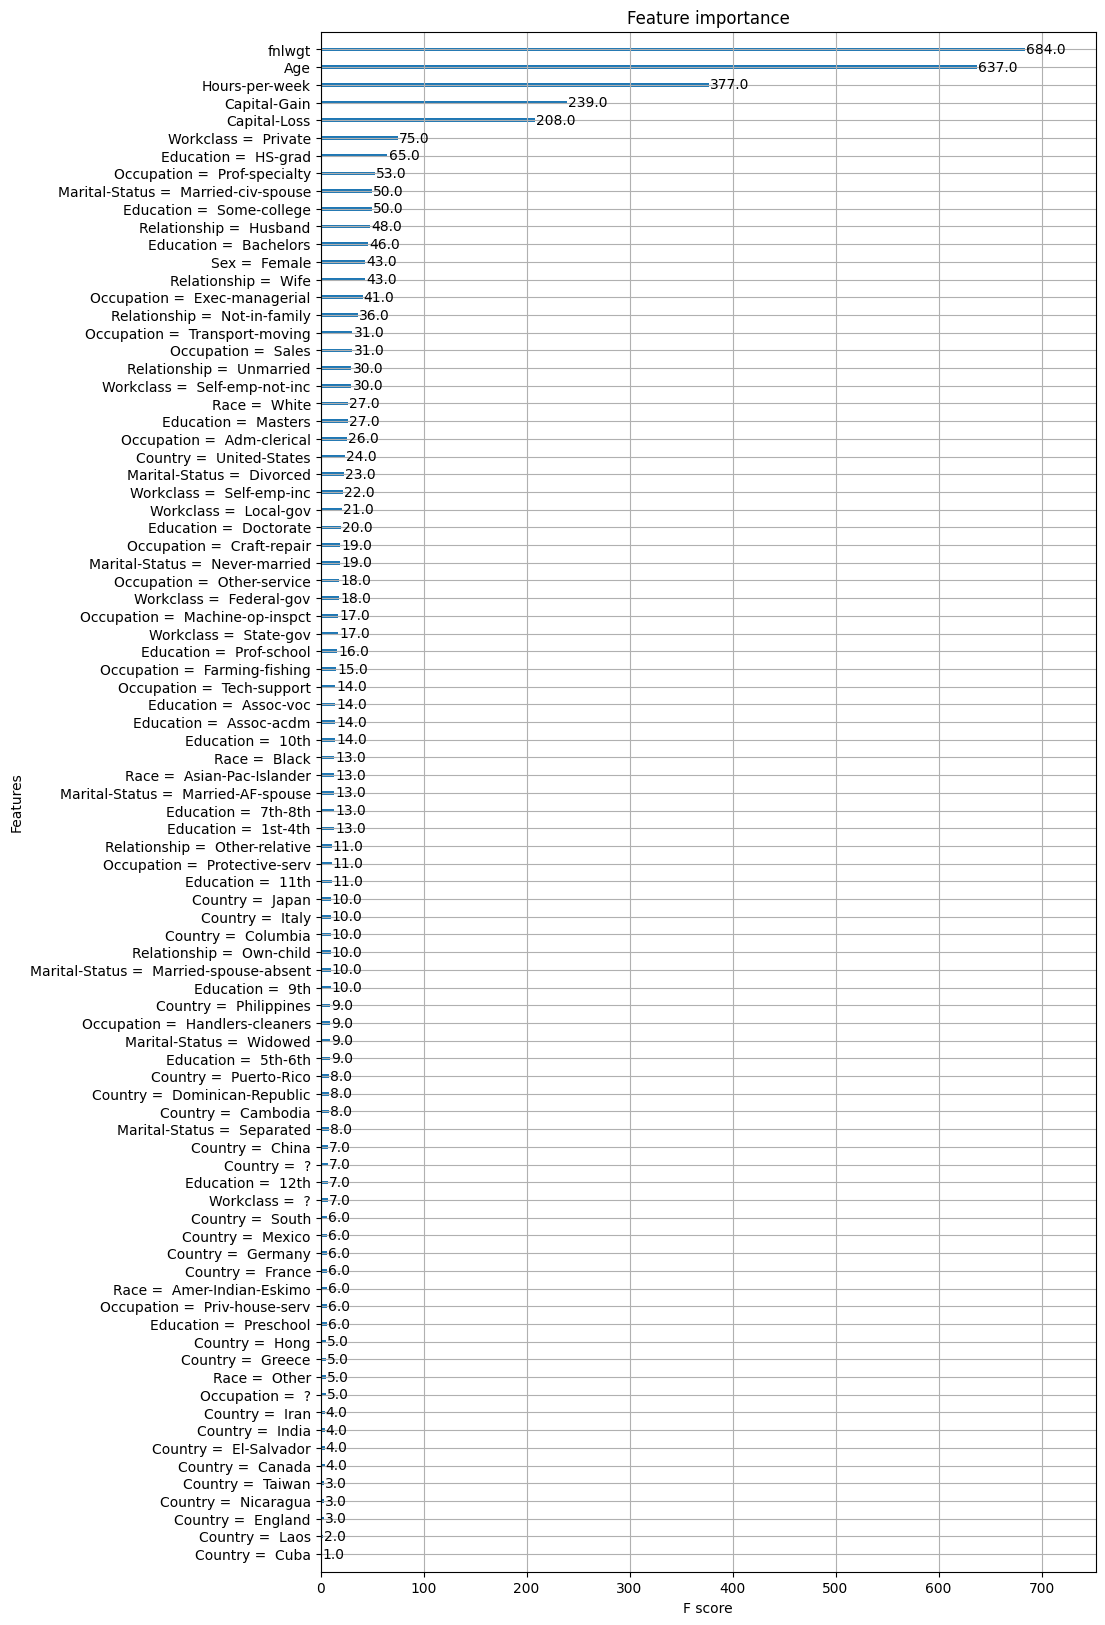

In [14]:
# Get feature names for the transformed dataset so that they'll show up on the plot -- don't worry about this bit
gbtree_features_orig = gbtree.get_booster().feature_names
gbtree_features = []
for cat_var in categorical_names:
    cat_var_names = [feature_names[cat_var] +" = " + cat for cat in categorical_names[cat_var]]
    gbtree_features.extend(cat_var_names)
gbtree_features.extend([feature_names[i] for i in range(len(feature_names)) if i not in categorical_features])
gbtree.get_booster().feature_names = gbtree_features

# Plot feature importances
plt.rcParams["figure.figsize"] = (10,20)
plot_importance(gbtree.get_booster())

Pick an interesting feature with a high importance in the plot above. Can you figure out their relationship with the outcome variable? (Is a higher or lower value more likely to indicate a high-income individual? For binary variables, is it 0 or 1?)

Text(0, 0.5, 'Number of People')

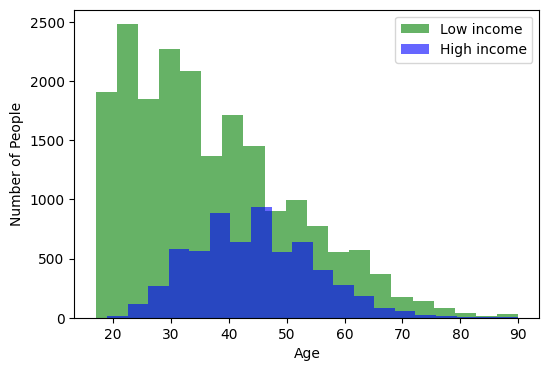

In [15]:
focus_feature = 'Age'
fig = plt.figure(figsize=(6, 4))
plt.hist(train[focus_feature][labels_train==0], bins = 20, label='Low income', color='g', alpha=0.6)
plt.hist(train[focus_feature][labels_train==1], bins = 20, label='High income', color='b', alpha=0.6)
plt.legend()
plt.xlabel(focus_feature)
plt.ylabel("Number of People")

If you have more time: the `plot_importance` function takes a parameter called `importance_type`, which you can read more about [in the documentation](https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.plotting). Try changing the importance type and re-making the plot. How does our explanation change?

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

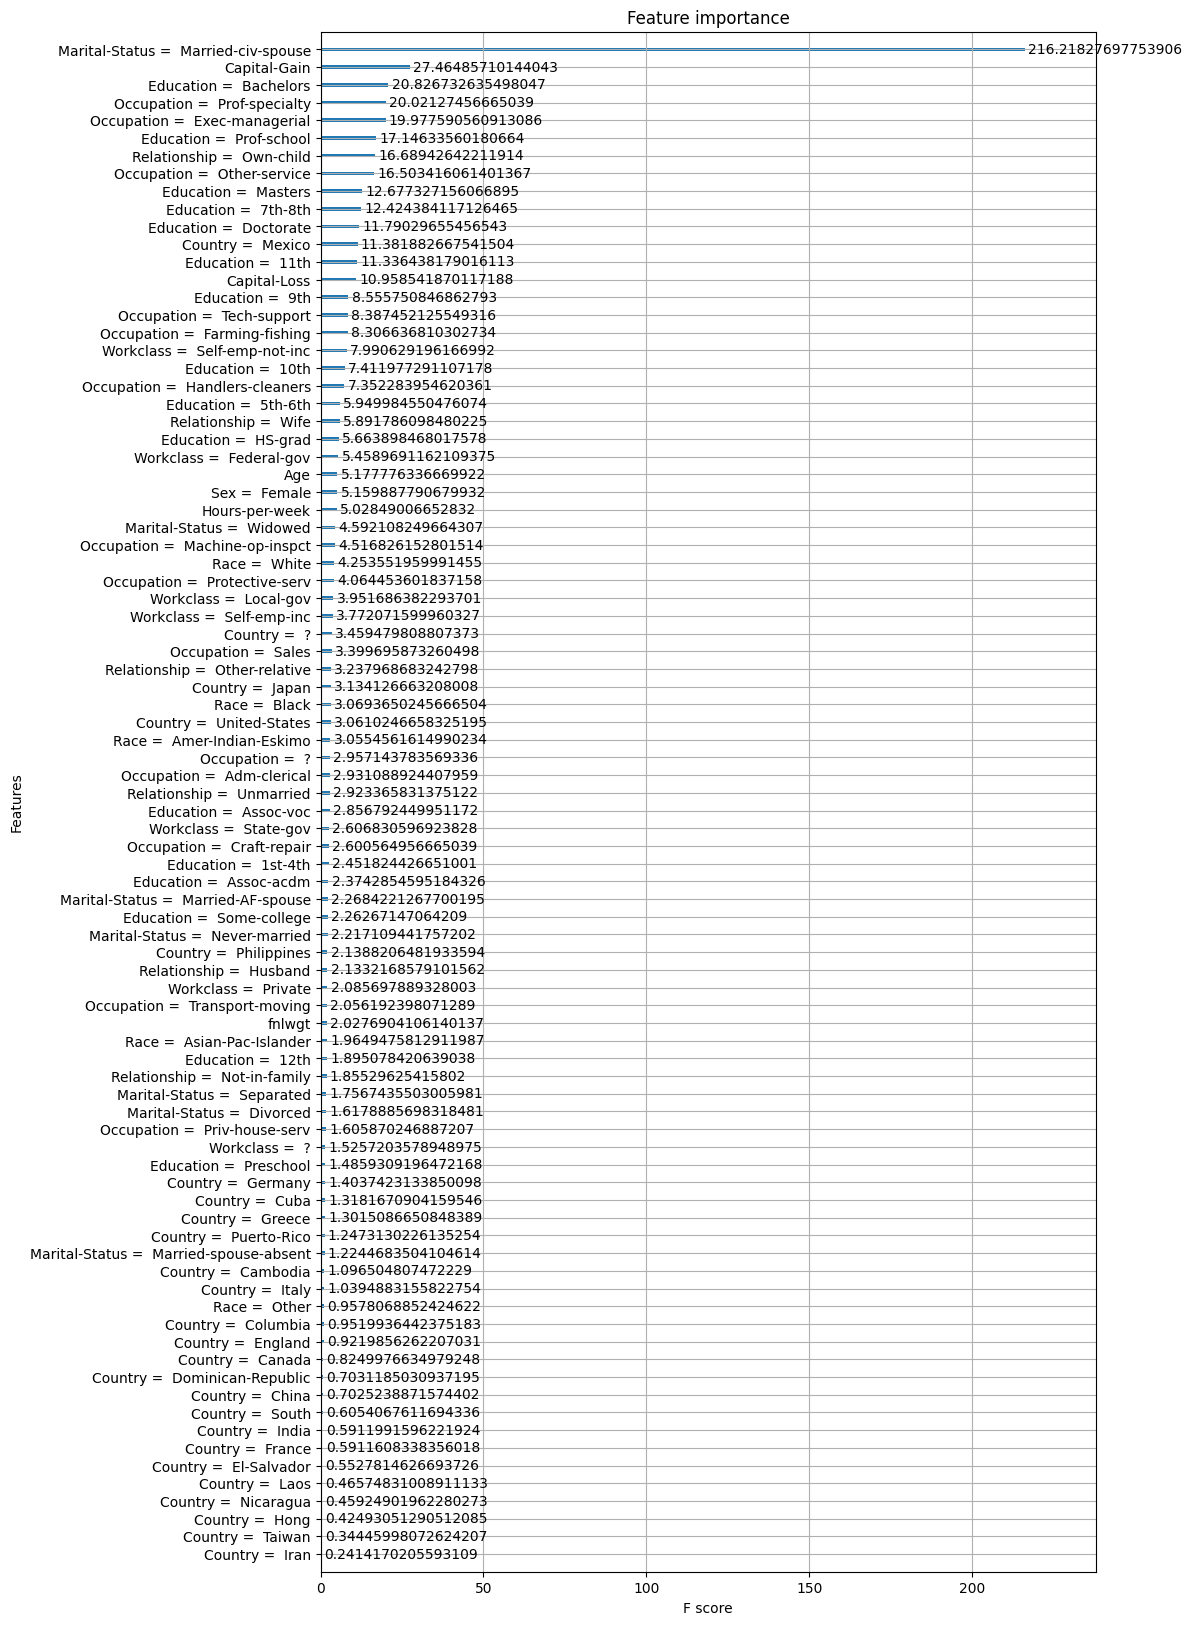

In [16]:
plot_importance(gbtree.get_booster(), importance_type = 'gain')

In [17]:
# Replace the original feature names, which LIME will expect
gbtree.get_booster().feature_names = gbtree_features_orig

## Part 4: Explaining predictions with LIME

Time for LIME!

Remember: Lime is _Locally Interpretable Model-Agnostic Explainaitions_. Very different from above.

### LIME Tabular Explainer

The tabular explainer is how we get locally interpretable explanations for models trained on tabular data.

First, we initialize an explainer object that takes in all the information we stored/encoded earlier about the dataset.

In [18]:
explainer = lime.lime_tabular.LimeTabularExplainer(train.values,
                                                   feature_names=feature_names,
                                                   class_names=class_names,
                                                   categorical_features=categorical_features,
                                                   categorical_names=categorical_names)

Next, we need to define a single function that takes in the form of data that LIME expects and returns the type of prediction that LIME expects. In particular,
- the input should be a numpy array (which we can get from a pandas DataFrame using `df.values`)
- the input features should human-understandable
- the input data should have each categorical variable in a single column
- the output should be a predicted probability (not a predicted class)

In [19]:
predict_fn = lambda x: gbtree.predict_proba(encoder.transform(x)).astype(float)

Now we have everything we need to use the explainer. Let's get an explanation for one of the examples in the test set.

In [20]:
i = 0
print('Predicted class: ', pred_labels_test[i])
print('Actual class: ', labels_test[i])
# Get explanation
exp = explainer.explain_instance((test.values[i]), predict_fn, num_features=5)

Predicted class:  0
Actual class:  0


/Users/leoyaoair23/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(


TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

The explanation can be presented as a list of weighted features.

In [22]:
exp.as_list()

NameError: name 'exp' is not defined

Text(0.5, 1.0, 'Local explanation for class  >50K')

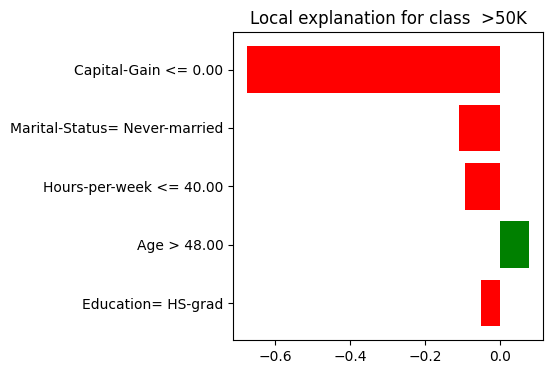

In [ ]:
# Visualize the explanation
%matplotlib inline

# fig = exp.as_pyplot_figure()
#   can serve the same purpose but with the version installed,
#   it's hard to control the details of the plot, such as the figure size
fig = plt.figure(figsize=(4, 4))
vals = [x[1] for x in exp.as_list(label=1)]
names = [x[0] for x in exp.as_list(label=1)]
vals.reverse()
names.reverse()
colors = ['green' if x > 0 else 'red' for x in vals]
pos = np.arange(len(exp.as_list(label=1))) + .5
plt.barh(pos, vals, align='center', color=colors)
plt.yticks(pos, names)
if exp.mode == "classification":
    title = 'Local explanation for class %s' % exp.class_names[1]
else:
    title = 'Local explanation'
plt.title(title)

The explanations can also be exported as an html page (which we can render here in this notebook), using D3.js to render graphs. You could also save the html page to a file if you wanted to.

In [ ]:
exp.show_in_notebook(show_all=True)

**To discuss:**
- How do we interpret this plot? That is, what do orange and blue mean? What's on the x axis?
- How does this explantion differ from the feature importance explanation given above?

### **TODO:** Now generate LIME explanations (in whichever format you chose) for some other examples in the test set. Are similar features important?

# write your answer here
There's an error (TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe'') in the getting the explanation code block. The following code can't run and I can't get another explanation. 

From comparing the two plots, we see that sex becomes important predictor in the second one, whereas it was not initially. Similarly, having a divorced marital status also becomes important in the second one. Conversely, being a high school graduae was initially an important predictor but is not anymore.

### LIME Submodular Picker

As we just saw, explanations can vary a lot depending on what instance we pick. While this is great for explaining a single prediction, it makes it hard to give someone general intuition for "how the model makes decision." That's where the submodular picker comes in. It picks useful, representative examples that together give global explanation for the model.

In broad strokes, the algorithm does the following:
1. Calculate an explanation for all examples in the dataset
2. Determine which features are important in explaining a lot of predictions -- that is, features that seem globally important
3. Select (greedily) examples where the top globally important feature is part of the local explanation for that one example's prediction
3. Continue selecting examples until we've covered as many of the globally important features as possible, constrained by the number of features that the user wants returned (num_exps_desired)

You can read the details of how this is done in the paper.

In [ ]:
# Initialize the SP object
sp_obj = submodular_pick.SubmodularPick(explainer, train.values, predict_fn, sample_size=10,
                                        num_features=5, num_exps_desired=5)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneHo

The attribute V tells us the best indices from the test set to explain the overall predictions of the classifier.

In [ ]:
sp_obj.V

[2, 5, 0, 9, 6]

Now, we can get explantions for each of those examples:

In [ ]:
for ind in sp_obj.V:
    exp = explainer.explain_instance(test.values[ind], predict_fn, num_features=5)
    print("Actual class: ", labels_test[ind])
    exp.show_in_notebook(show_all=False)
    print("==========================")

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(


Actual class:  1


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(


Actual class:  0


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(


Actual class:  0


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(


Actual class:  0


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(


Actual class:  0


## **Todo:** Based on these carefully chose examples, what would you say to someone who wanted to know how our model makes decisions?

**Write your answer in this text cell:**
I would say to them that there is a problem with LIME that interpretations can differ with different people. If we take the exact same person and change only one or two things, we will end up getting very different results which don’t make sense. And that’s the reason why a lot of people don’t use it in practice. In contrast, SHAP is stable.